In [1]:
import numpy as np
import keras
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM,Bidirectional
import re
import tensorflow as tf
from keras.preprocessing.text import Tokenizer

In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool1D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sa-bangla-binary-restaurant-review/Bert_Preprocessed_Restaurant_Review_Dataset.xlsx


In [4]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 KB 514.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
df=pd.read_excel('/kaggle/input/sa-bangla-binary-restaurant-review/Bert_Preprocessed_Restaurant_Review_Dataset.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    1431 non-null   int64 
 1   Unnamed: 0.1  1431 non-null   int64 
 2   Reviews       1431 non-null   object
 3   Sentiment     1431 non-null   object
 4   Text          1431 non-null   object
 5   Label         1431 non-null   int64 
 6   Token         1431 non-null   object
 7   Token_ID      1431 non-null   object
dtypes: int64(3), object(5)
memory usage: 89.6+ KB


In [6]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Reviews,Sentiment,Text,Label,Token,Token_ID
0,501,501,পরিবেশ খাদ্য ও সেবা ছিল মহান,positive,পরিবেশ খাদ্য ও সেবা ছিল মহান,1,"['পরিবেশ', 'খাদ', '##য', 'ও', 'সেবা', 'ছিল', '...","[2679, 19673, 9294, 2038, 2872, 2072, 4444]"
1,264,264,খাবারগুলো এত ইয়াম্মিইইইই...ইচ্ছে করে প্রতিদিন ...,positive,খাবারগুলো এত ইয়াম্মিইইইইইচ্ছে করে প্রতিদিন খাই,1,"['খাবার', '##গলে', '##া', 'এত', 'ই', '##যাম', ...","[2545, 64716, 2395, 2592, 2554, 71968, 6968, 2..."
2,405,405,শহরে সেরা মুরগির রেসিপি জন্য নিঃসন্দেহে জায়গা,positive,শহরে সেরা মুরগির রেসিপি জন্য নিঃসন্দেহে জায়গা,1,"['শহরে', 'সেরা', 'মর', '##গির', 'রেসিপি', 'জন'...","[2881, 2617, 18849, 25654, 10643, 2181, 9294, ..."
3,435,435,আজ রাতে আমি কাবাব ও খাদ্য এ আমার পরিবারের সাথে...,positive,আজ রাতে আমি কাবাব ও খাদ্য এ আমার পরিবারের সাথে...,1,"['আজ', 'রাতে', 'আমি', 'কাবাব', 'ও', 'খাদ', '##...","[2145, 2736, 2169, 12677, 2038, 19673, 9294, 2..."
4,1001,1001,বেইলি রোড শাখাতে সুপার ধীর সেবা,negative,বেইলি রোড শাখাতে সুপার ধীর সেবা,0,"['বেইলি', 'রে', '##াড', 'শাখা', '##তে', 'সপ', ...","[14379, 4972, 35897, 3574, 2200, 73835, 3187, ..."


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

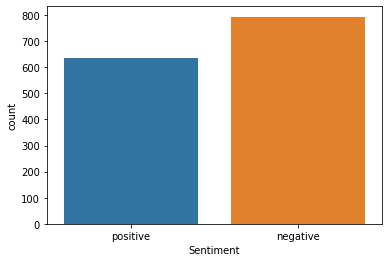

In [7]:
sns.countplot(df['Sentiment'])

In [8]:
df.Sentiment.value_counts(), len(df)

(negative    794
 positive    637
 Name: Sentiment, dtype: int64,
 1431)

In [9]:
maxlen = 200
max_features = 10000
batch_size = 32

In [10]:
df['Text']=df['Text'].astype('str')

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['Text'],df['Label'] , test_size=0.1,random_state=2)
x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train,test_size=0.1,random_state=42)

In [12]:
vocab_size=15000

In [13]:
tokenizer  = Tokenizer(num_words = max_features,oov_token = "<OOV>")
tokenizer.fit_on_texts(df['Text'])

train_seq =  tokenizer.texts_to_sequences(x_train)
val_seq =  tokenizer.texts_to_sequences(x_validation)
test_seq = tokenizer.texts_to_sequences(x_test)

In [14]:
x_train = pad_sequences(train_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post') #maxlen = maxlen, padding='post')
x_validation = pad_sequences(val_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post') #maxlen = maxlen, padding='post')
x_test = pad_sequences(test_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post') #maxlen = maxlen, padding='post')

In [15]:
model= Sequential()
model.add(Embedding(vocab_size,40,input_length=maxlen,name='Embedding'))
model.add(Conv1D(200, kernel_size=3, activation = "relu"))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(12, activation='relu'))
model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))
adam=Adam(learning_rate=0.003)
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_accuracy'])

2022-04-17 20:57:13.867481: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 200, 40)           600000    
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 200)          24200     
_________________________________________________________________
bidirectional (Bidirectional (None, 198, 256)          336896    
_________________________________________________________________
dropout (Dropout)            (None, 198, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6

In [16]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

In [17]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=30, callbacks=[early_stopping],verbose=1, validation_data=(x_validation, y_validation))

2022-04-17 20:57:15.754819: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
37/37 [==============================] - 51s 1s/step - loss: 0.6762 - binary_accuracy: 0.5656 - val_loss: 0.5320 - val_binary_accuracy: 0.7364
Epoch 2/30
37/37 [==============================] - 40s 1s/step - loss: 0.4996 - binary_accuracy: 0.7625 - val_loss: 0.4650 - val_binary_accuracy: 0.7597
Epoch 3/30
37/37 [==============================] - 38s 1s/step - loss: 0.2855 - binary_accuracy: 0.8834 - val_loss: 0.3481 - val_binary_accuracy: 0.8760
Epoch 4/30
37/37 [==============================] - 38s 1s/step - loss: 0.1671 - binary_accuracy: 0.9456 - val_loss: 0.3632 - val_binary_accuracy: 0.8915
Epoch 5/30
37/37 [==============================] - 41s 1s/step - loss: 0.1048 - binary_accuracy: 0.9715 - val_loss: 0.3497 - val_binary_accuracy: 0.8760
Epoch 6/30
37/37 [==============================] - 41s 1s/step - loss: 0.0448 - binary_accuracy: 0.9905 - val_loss: 0.5748 - val_binary_accuracy: 0.8605
Epoch 7/30
37/37 [==============================] - 43s 1s/step - loss: 0.03

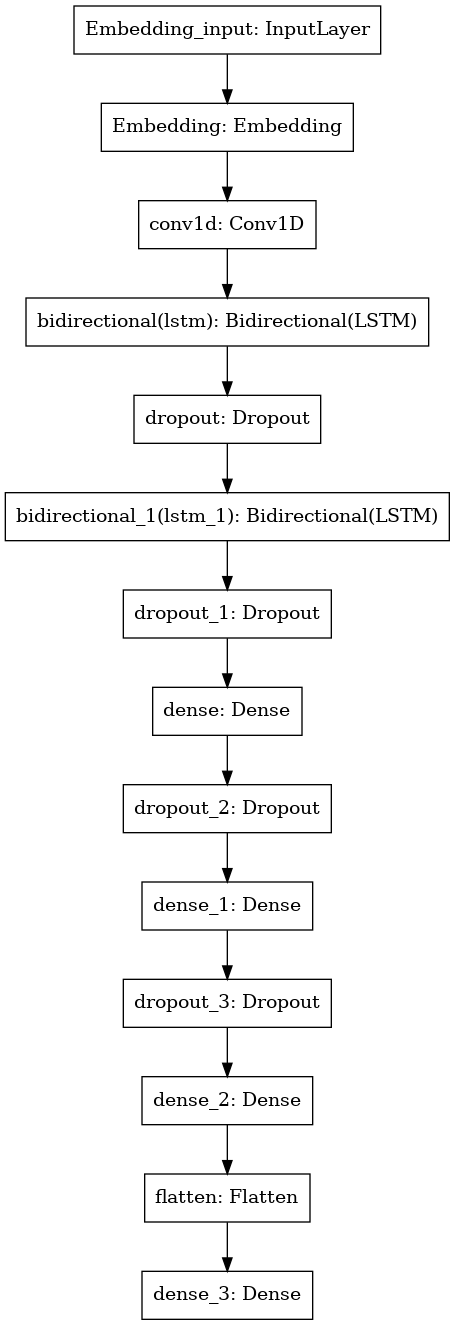

In [18]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [19]:
model.evaluate(x_test, y_test)

5/5 [==============================] - 1s 283ms/step - loss: 0.3420 - binary_accuracy: 0.9167


[0.3419656753540039, 0.9166666865348816]

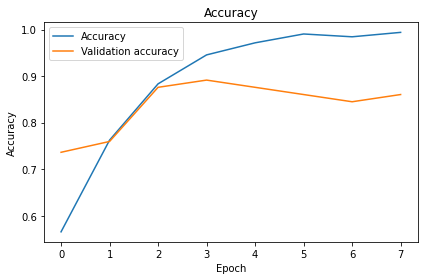

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'], label="Accuracy")
plt.plot(history.history['val_binary_accuracy'], label="Validation accuracy")
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

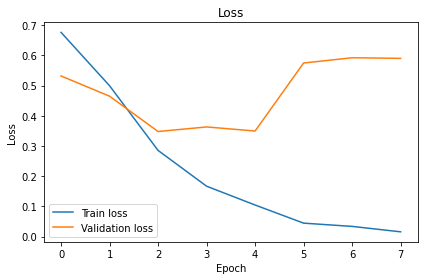

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Train loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test)

In [23]:
y_pred = y_pred.reshape(-1,1)
y_pred = np.round(y_pred)

In [24]:
print(y_pred)
print(y_test)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]]
1355    0
553     0
1195    0
1389    1
551     0
       ..
801     1
365     0
477     0
839     0
1064    1
Name: Label, Length: 144,

In [25]:
categories = ['negative','positive']
print(classification_report(y_test, y_pred, target_names=categories))

              precision    recall  f1-score   support

    negative       0.89      0.96      0.92        74
    positive       0.95      0.87      0.91        70

    accuracy                           0.92       144
   macro avg       0.92      0.92      0.92       144
weighted avg       0.92      0.92      0.92       144



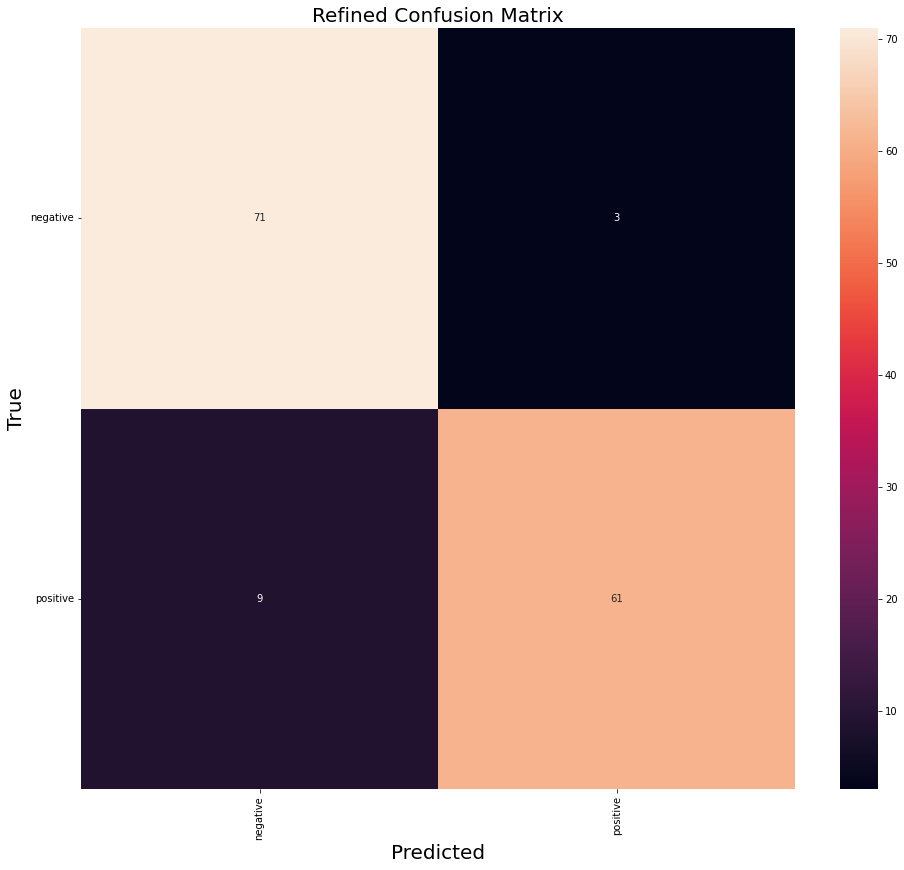

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)


cm = confusion_matrix(y_test, y_pred)

## Get Class Labels
labels = 2
#[0,1,2,3,4,5]_
class_names = categories 

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()